In [1]:
# --- Install required packages ---

!apt install -y libopenmpi-dev openmpi-bin
!pip install mpi4py

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopenmpi-dev is already the newest version (4.1.2-2ubuntu1).
openmpi-bin is already the newest version (4.1.2-2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [2]:
# --- Download lec06_mpi_grad_shafranov.py ---

!wget https://raw.githubusercontent.com/smaeyama/lec_SOKENDAI_Simulation_Science/main/fss2025/lec06_mpi/lec06_mpi_grad_shafranov.py

--2026-01-14 20:39:44--  https://raw.githubusercontent.com/smaeyama/lec_SOKENDAI_Simulation_Science/main/fss2025/lec06_mpi/lec06_mpi_grad_shafranov.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8085 (7.9K) [text/plain]
Saving to: ‘lec06_mpi_grad_shafranov.py’

lec06_mpi_grad_shaf 100%[===================>]   7.90K  --.-KB/s    in 0s      

2026-01-14 20:39:44 (109 MB/s) - ‘lec06_mpi_grad_shafranov.py’ saved [8085/8085]



In [3]:
# --- Run MPI application ---
# !mpirun -np 6 python3 "lec06_mpi_grad_shafranov.py"

# --- Options for Google Colab ---
#  Generally, the option --allow-run-as-root is not recommended. Root privileges have less impact in Google Colab, because it is a temporary workspace.
!mpirun --allow-run-as-root --oversubscribe -np 6 python3 "lec06_mpi_grad_shafranov.py"

[rank 3] → (rankz, rankr) = (1, 0)
[rank 0] → (rankz, rankr) = (0, 0)
[rank 5] → (rankz, rankr) = (1, 2)
[rank 2] → (rankz, rankr) = (0, 2)
[rank 1] → (rankz, rankr) = (0, 1)
[rank 4] → (rankz, rankr) = (1, 1)
[rank 2] neighbors: {'up': 5, 'down': -2, 'left': 1, 'right': -2}
[rank 0] neighbors: {'up': 3, 'down': -2, 'left': -2, 'right': 1}
[rank 4] neighbors: {'up': -2, 'down': 1, 'left': 3, 'right': 5}
[rank 1] neighbors: {'up': 4, 'down': -2, 'left': 0, 'right': 2}
[rank 5] neighbors: {'up': -2, 'down': 2, 'left': 4, 'right': -2}
[rank 3] neighbors: {'up': -2, 'down': 0, 'left': -2, 'right': 4}
Converged at iter = 144, error = 0.009480042859605693
Converged at iter = 144, error = 0.009480042859605693
Converged at iter = 144, error = 0.009480042859605693
Converged at iter = 144, error = 0.009480042859605693
Converged at iter = 144, error = 0.009480042859605693
(42, 32) (42, 32) (42, 32)
Converged at iter = 144, error = 0.009480042859605693
(42, 32) (42, 32) (42, 32)
(42, 32) (42, 32) 

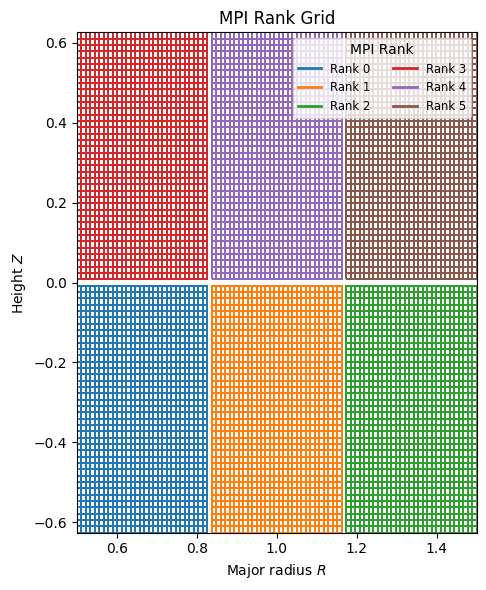

In [4]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

file_list = sorted(glob.glob("psi.*.nc"))         # Collect all MPI rank output files

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
cmap = plt.get_cmap("tab10")                      # Discrete colormap for rank coloring
legend_elements = []

for i, fname in enumerate(file_list):
    ds = xr.open_dataset(fname)                   # Load local grid data of each MPI rank
    r = ds["r"]                                   # Local R-coordinates
    z = ds["z"]                                   # Local Z-coordinates
    color = cmap(i % cmap.N)                      # Assign a unique color per rank
    ax.pcolormesh(r, z, np.zeros_like(ds["psi"])[:-1, :-1],  # Draw mesh edges
        shading="auto", edgecolor=color, facecolor='none', linewidth=0.2)
    legend_elements.append(Line2D([0], [0], color=color, lw=2, label=f"Rank {i}"))
                                                  # Legend entry for each rank
    ds.close()

ax.set_xlabel(r'Major radius $R$')
ax.set_ylabel(r'Height $Z$')
ax.set_aspect('equal', adjustable='box')
ax.set_title("MPI Rank Grid")
ax.legend(handles=legend_elements, title="MPI Rank", loc="upper right", fontsize="small", ncol=2)
fig.tight_layout()
plt.show()

<xarray.Dataset> Size: 59kB
Dimensions:  (z: 80, r: 90)
Coordinates:
  * z        (z) float64 640B -0.6261 -0.6102 -0.5944 ... 0.5944 0.6102 0.6261
  * r        (r) float64 720B 0.5 0.5112 0.5225 0.5337 ... 1.466 1.478 1.489 1.5
Data variables:
    psi      (z, r) float64 58kB dask.array<chunksize=(40, 30), meta=np.ndarray>


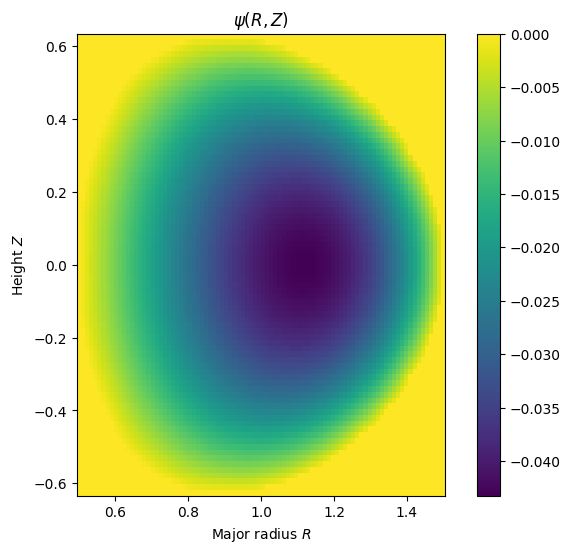

In [5]:
ds = xr.open_mfdataset("psi.*.nc")  # Open and merge all per-rank NetCDF files into one dataset
print(ds)                           # Display merged dataset structure and coordinates
r = ds["r"]                         # Global R-coordinate array
z = ds["z"]                         # Global Z-coordinate array
psi = ds["psi"]                     # Global psi array

fig = plt.figure(figsize=(8.2, 6))
ax = fig.add_subplot()
quad = ax.pcolormesh(r, z, psi, shading="auto")
ax.set_xlabel(r'Major radius $R$')
ax.set_ylabel(r'Height $Z$')
ax.set_aspect('equal', adjustable='box')
ax.set_title(r"$\psi(R,Z)$")
fig.colorbar(quad)
plt.show()

ds.close()